In [1]:
import random as rand
import json
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta
from datetime import datetime

from matplotlib import pyplot as plt
from Port.Sharp import SharpPortfolio
from Port.Markowitz_scipy import MarkowitzPortfolio
from Port.Tobin_scipy import TobinPortfolio

# Загрузка данных для работы

In [2]:
with open('utils/config.json', 'r') as file:
    config = json.load(file)
    
start = config['start_date']
end = config['end_date']
riskfree = config['riskless_rate']
riskfree_day = ((1+riskfree)**(1/252))-1

In [7]:
# def get_sp_data(start=start, end=end):
#     # Get the current SP components, and get a tickers list
#     sp_assets = pd.read_html(
#         'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
#     assets = sp_assets['Symbol'].str.replace('.', '-').tolist()
#     # Download historical data to a multi-index DataFrame
#     try:
#         data = yf.download(assets, start=start, end=end, as_panel=False)
#         filename = 'sp_components_data.pkl'
#         data.to_pickle(filename)
#         print('Data saved at {}'.format(filename))
#     except ValueError:
#         print('Failed download, try again.')
#         data = None
#     return data


# if __name__ == '__main__':
#     data = get_sp_data()

In [8]:
# pct = data.pct_change().iloc[1:,]
# pct.to_excel('returns.xlsx')

In [20]:
sp500 = pd.read_excel('Data/sp500.xlsx', index_col=0)
sp500 = sp500.pct_change().iloc[1: ]
pct = pd.read_excel('Data/returns.xlsx', index_col = 0)

In [10]:
pct = pct.dropna(axis=1)

# Метрики

In [11]:
def get_metrics(df_data):  
    metr = pd.DataFrame()
    
    #Average daily returns
    mean = df_data.mean()
    metr['AVG_returns'] = mean

    #Risk
    risk = df_data.std()
    metr['Risk'] = risk

    #Beta

    var_metr = df_data.var()
    cov_metr = df_data.cov()
    beta = cov_metr['sp500']/var_metr['sp500']

    metr['Beta'] = beta

    #Alpha

    riskf_daily = ((1+riskfree)**(1/252))-1
    alpha = metr['AVG_returns'] - (riskf_daily + metr['Beta']*(mean['sp500'] - riskf_daily))
    metr['Alpha'] = alpha

    #VaR(95%)

    VaR = - risk*1.65
    metr['VaR(95%)'] = VaR

    return metr

# Бэктест 

In [12]:
def backtesting_universal(data, # df with pct_changes
                          port_model = MarkowitzPortfolio,
                          window_train = 24, 
                          window_test = 1,
                          train_start_year = 2018, 
                          train_start_month = 1,
                          test_finish_year = 2022,
                          test_finish_month = 11,
                          **args):
    

    
    weights_year = []
    return_portfolio = pd.DataFrame([])
    
    train_start_month = train_start_year * 12 + train_start_month - 1
    test_finish_month = test_finish_year * 12 + test_finish_month - 1
    train_finish_month = test_finish_month - window_train - window_test + 1
    
    for train_start_per in range(train_start_month, train_finish_month, window_test):
        
        train_finish_per = train_start_per + window_train
        
        train_year_start_per = train_start_per // 12
        train_month_start_per = train_start_per % 12 + 1
        
        train_year_finish_per = train_finish_per // 12
        train_month_finish_per = train_finish_per % 12 + 1
        
                
        mask_train = (data.index > datetime(train_year_start_per, train_month_start_per, 1)) & (data.index < datetime(train_year_finish_per, train_month_finish_per, 1))
        data_train_per = data[mask_train]
        
        
        mu = (((data_train_per + 1).prod()) ** (1 / len(data_train_per)) - 1).values * 252  # средняя доходность за год (252 раб дня)
        Sigma = data_train_per.cov().values * 252  # ковариационная матрица за год (252 раб дня)

        port_ = port_model(mu, Sigma, args=args)
        weights, _ = port_.fit()
        weights_year.append(weights)
        
        
        test_year_start_per = train_year_finish_per
        test_month_start_per = train_month_finish_per
        
        test_finish_per = train_finish_per + window_test
        
        test_year_finish_per = test_finish_per // 12
        test_month_finish_per = test_finish_per % 12 + 1
        
        # print(train_year_start_per, train_month_start_per,  train_year_finish_per, train_month_finish_per, test_year_finish_per, test_month_finish_per)
        
                
        mask_test = (data.index > datetime(test_year_start_per, test_month_start_per, 1)) & (data.index < datetime(test_year_finish_per, test_month_finish_per, 1))
        data_test_per = data[mask_test]
        
        #print(data_test_per, weights)
        #print(data_test_per.shape, weights.shape)
        return_portfolio_loc = pd.DataFrame(data_test_per.values @ weights, index=data_test_per.index,
                                            columns=[f'{port_model.__name__}'])
        

        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
    
    return_portfolio['sp500'] = sp500.loc[return_portfolio.index]

    return return_portfolio

# Создание портфеля

In [13]:
def get_port(asset_list, portfolio_type = MarkowitzPortfolio, max_risk=1, min_ret=((1+riskfree)**(1/252))-1):
    asset_pct = pct[asset_list]
    
    global risk
    global ret 
    risk = max_risk
    ret = min_ret
    
    asset_rets = backtesting_universal(asset_pct, port_model = portfolio_type, ret_det=ret, risk_det=risk)
    
    asset_price = (asset_rets+1).cumprod()
    plt.plot(asset_price)
    plt.show()
    return asset_rets, asset_price

# Baseline

In [14]:
all_assets = pct.columns

def select_rand(n=1):
    rand_ports = pd.DataFrame()
    metr = pd.DataFrame()
    
    for i in range(n):
        pick = rand.sample(list(all_assets),20)
        assets = pct[pick]
        port = backtesting_universal(assets,ret_det=(1 + riskfree)**(1/252) - 1)
        jeeja = get_metrics(port).drop('sp500', axis = 0)
        metr = pd.concat([metr, jeeja],axis = 0)
    return metr

x = select_rand(2)
# sd = x.mean()
# sd

# Шарп

In [15]:
def get_sharpe(df_pct,n):
    sharpe = (df_pct.mean() - riskfree_day)/df_pct.std()
    sharpe = sharpe.sort_values(ascending=False)
    return sharpe.head(n).index.to_list()

In [16]:
sharp_list = get_sharpe(pct, 20)

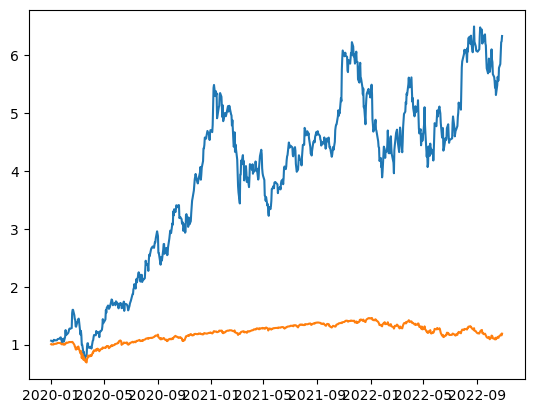

In [17]:
sharp_ret, sharp_price = get_port(sharp_list, TobinPortfolio)

In [60]:
sharp_metr = get_metrics(sharp_ret)
sharp_metr

,AVG_returns,Risk,Beta,Alpha,VaR(95%)
TobinPortfolio,0.003374,0.037448,1.484708,2.861589e-03,-0.061790
sp500,0.000384,0.016174,1.000000,-4.336809e-19,-0.026687


# Sortino

In [13]:
def get_sortino(df_pct,n):
    down_risk = pct[pct<0].std()
    sortino = (df_pct.mean() - riskfree_day)/down_risk
    sortino = sortino.sort_values(ascending=False)
    return sortino.head(n).index.to_list()

In [14]:
sortino_list = get_sortino(pct,20)

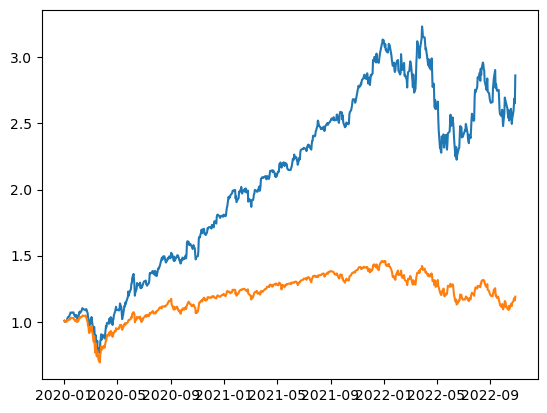

In [116]:
sortino_ret, sortino_price = get_port(sortino_list)

In [88]:
sortino_metr = get_metrics(sortino_ret)
sortino_metr

,AVG_returns,Risk,Beta,Alpha,VaR(95%)
MarkowitzPortfolio,0.001746,0.021034,1.125092,1.329125e-03,-0.034706
sp500,0.000384,0.016174,1.000000,-4.336809e-19,-0.026687


# PEG

In [63]:
# ps_df = pd.DataFrame()

# for company in pct.columns:   
#     firm = yf.Ticker(company)
#     dict =  firm.info
#     ps_df[company] = [dict['priceToSalesTrailing12Months']]

In [64]:
# ps_df = ps_df.T
ps_df = pd.read_excel('ps.xlsx', index_col=0)
ps_df = ps_df.sort_values(by=0, ascending=0)

In [65]:
ps_list = list(ps_df.head(20).index)

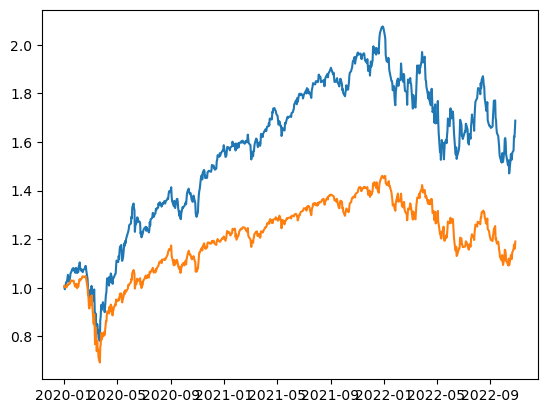

In [74]:
ps_ret, ps_price = get_port(ps_list, SharpPortfolio)

In [104]:
ps_metr = get_metrics(ps_ret)

# Alpha/Beta

In [68]:
ab_ratio = pd.DataFrame()

pct['sp500']= sp500

#Mean

mean_pct = pct.mean()

#Beta

var_pct = pct.var()
cov_pct = pct.cov()
beta = cov_pct['sp500']/var_pct['sp500']


#Alpha

riskf_daily = ((1+riskfree)**(1/252))-1
alpha = mean_pct - (riskf_daily + beta*(mean_pct['sp500'] - riskf_daily))

ab_ratio['Ratio'] = alpha/beta

In [69]:
ab_list = list(ab_ratio.sort_values(by='Ratio', ascending=0).head(20).index)

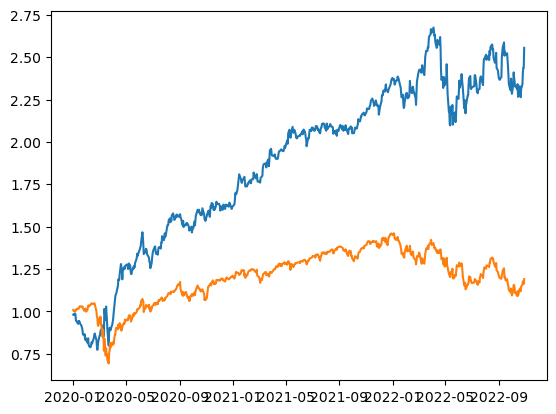

In [72]:
ab_ret, ab_price = get_port(ab_list, SharpPortfolio)

In [110]:
ab_metr = get_metrics(ab_ret)

#### Создаём датафрейм

In [193]:
pct = pd.read_excel('Data/tick/assets.xlsx', index_col=0)
pct = pct.pct_change()
pct = pct.iloc[1:,:].dropna(axis = 1)

sp500 = pd.read_excel('Data/tick/sp500.xlsx', index_col=0)
sp500 = sp500.pct_change().iloc[1: ]

# Создание словаря с методами кластеризации

#### Настраиваем размерность (не все активы из prediction_table есть в pct)

In [35]:
need = np.transpose(pct)
x = list(set(df.index) - set(need.index))
df = df.drop(x, axis = 0)

In [36]:
cols = df.columns[1:]
all_assets = {}
for col in cols:
    assets = {}
    for i in set(df[col].unique()):
        assets[i] = list(df.loc[df[col] == i].index.values)
    all_assets[col] = assets

# Создаём словарь с расчётом Шарпа для всех активов в кластере для каждого метода

In [37]:
# Словарь имеет вид: { "метод кластеризации" : { "номер кластера" : { "актив" : коэффициент Шарпа} } }

def clust_sharpe(dict_assets, df_pct):   
    assets_port = {}
    
    for method in list(dict_assets.keys()):    
        clust_method = {}

        for cluster in list(dict_assets[method].keys()):
            assets_use = {}

            for asset in list(dict_assets[method][cluster]):
                sharpe = (df_pct[asset].mean() - riskfree)/df_pct[asset].std()
                assets_use[asset] = sharpe
            
            clust_method[cluster] = assets_use
        
        assets_port[method] = clust_method
        
    return assets_port

In [38]:
shar = clust_sharpe(all_assets, pct)

# Выбираем топ 2 актива по Шарпу из каждого кластера и передаём значения в словаь с методами

In [39]:
def clust_top_sharpe(assets_port):
    top2_Sharpe = {}
    
    for method in list(assets_port.keys()):
        list_of_assets = []
        
        for cluster in list(assets_port[method].keys()):

            for asset in list(assets_port[method][cluster].keys()):             
                if len(assets_port[method][cluster]) > 2:
                    del assets_port[method][cluster][min(assets_port[method][cluster], key = assets_port[method][cluster].get)]
            
            for asset in list(assets_port[method][cluster].keys()):
                list_of_assets.append(asset)
                
        top2_Sharpe[method] = list_of_assets

    return top2_Sharpe       #возвращаем словарь вида { "метод кластеризации" : [активы] }

In [40]:
ports = clust_top_sharpe(shar)

# Создаём портфели на основе выбранных тикеров

#### Определяем функцию для создания портфелей

In [41]:
def calc_ports(test, riskless_ret, index, mu, sigma):
    sharp_values, markov_values, tobin_values, traynor_values, qsharp_values = [], [], [], [], []
    
    # Расчёт Шарпа
    
    sharp = SharpPortfolio(mu, sigma, riskless_ret)
    s = sharp.fit()[0]

    
    # Расчёт Марковица
   
    markov = MarkowitzPortfolio(mu, sigma, index.mean())
    m = markov.fit()[0]

    # Расчёт Тобина

    tobin = TobinPortfolio(mu, sigma, riskless_ret, index.std())
    t = tobin.fit()[0]
    
    #Расчёт тривиального портфеля
    
    n = len(list(test.columns))
    triv = [1/n]*n


    df_all_ports = pd.DataFrame({'Ticker':list(test.columns),
                                 'Sharpe':s,
                                 'Markowitz':m,
                                 'Tobin':t,
                                 'Trivial':triv})
    return df_all_ports

#### (тест работы функции)

In [42]:
# train = pct.iloc[:len(pct)//2,] #первая половина периода

In [43]:
# test = train[ports['original_n']]
# riskless_ret = (1 + riskfree)**(1/252) - 1
# index = sp500.iloc[:len(pct)//2,]

# mu = test.mean().values
# sigma = test.cov().values

# dict_ports = calc_ports(test, riskless_ret, index, mu, sigma)
# dict_ports = dict_ports.sort_values('Ticker')
# dict_ports

In [44]:
# pred = pct.iloc[len(pct)//2: ,]
# pred = pred[pred.columns.intersection(ports['orig__rando'])]
# pred.mul(list(dict_ports['Sharpe']), axis = 1)
# pred['orig__rando'] = pred.sum(axis = 1)

# Составляем портфели на "будущее" на основе трейна

#### Backtesting

In [45]:
# def backtesting_universal(data, # df with pct_changes
#                           port_model,
#                           window_train = 24, 
#                           window_test = 1, 
#                           period_iteration = 1,
#                           train_start_year = 2018, 
#                           train_start_month = 1,
#                           test_finish_year = 2022,
#                           test_finish_month = 11,
#                           **args):
    
#     weights_year = []
#     return_portfolio = pd.DataFrame([])
    
#     train_start_month = train_start_year * 12 + train_start_month - 1
#     test_finish_month = test_finish_year * 12 + test_finish_month - 1
#     train_finish_month = test_finish_month - window_train - window_test + 1
    
#     for train_start_per in range(train_start_month, train_finish_month, period_iteration):
        
#         train_finish_per = train_start_per + window_train
        
#         train_year_start_per = train_start_per // 12
#         train_month_start_per = train_start_per % 12 + 1
        
#         train_year_finish_per = train_finish_per // 12
#         train_month_finish_per = train_finish_per % 12 + 1
        
                
#         mask_train = (data.index > datetime(train_year_start_per, train_month_start_per, 1)) & (data.index < datetime(train_year_finish_per, train_month_finish_per, 1))
#         data_train_per = data[mask_train]
        
        
#         mu = (((data_train_per + 1).prod()) ** (1 / len(data_train_per)) - 1).values * 252  # средняя доходность за год (252 раб дня)
#         Sigma = data_train_per.cov().values * 252  # ковариационная матрица за год (252 раб дня)

#         port_ = port_model(mu, Sigma, args=args)
#         weights, _ = port_.fit()
#         weights_year.append(weights)
        
        
#         test_year_start_per = train_year_finish_per
#         test_month_start_per = train_month_finish_per
        
#         test_finish_per = train_finish_per + window_test
        
#         test_year_finish_per = test_finish_per // 12
#         test_month_finish_per = test_finish_per % 12 + 1
        
#         print(train_year_start_per, train_month_start_per,  train_year_finish_per, train_month_finish_per, test_year_finish_per, test_month_finish_per)
        
                
#         mask_test = (data.index > datetime(test_year_start_per, test_month_start_per, 1)) & (data.index < datetime(test_year_finish_per, test_month_finish_per, 1))
#         data_test_per = data[mask_test]
        
#         #print(data_test_per, weights)
#         #print(data_test_per.shape, weights.shape)
#         return_portfolio_loc = pd.DataFrame(data_test_per.values @ weights, index=data_test_per.index,
#                                             columns=['portfolio'])
        

#         return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])

#     return weights_year, return_portfolio

        

#### Моё

In [ ]:
def backtesting_universal(data, # df with pct_changes
                          port_model = MarkowitzPortfolio,
                          window_train = 24, 
                          window_test = 1, 
                          train_start_year = 2018, 
                          train_start_month = 1,
                          test_finish_year = 2022,
                          test_finish_month = 11,
                          **args):
    
    weights_year = []
    return_portfolio = pd.DataFrame([])
    
    train_start_month = train_start_year * 12 + train_start_month - 1
    test_finish_month = test_finish_year * 12 + test_finish_month - 1
    train_finish_month = test_finish_month - window_train - window_test + 1
    
    for train_start_per in range(train_start_month, train_finish_month, window_test):
        
        train_finish_per = train_start_per + window_train
        
        train_year_start_per = train_start_per // 12
        train_month_start_per = train_start_per % 12 + 1
        
        train_year_finish_per = train_finish_per // 12
        train_month_finish_per = train_finish_per % 12 + 1
        
                
        mask_train = (data.index > datetime(train_year_start_per, train_month_start_per, 1)) & (data.index < datetime(train_year_finish_per, train_month_finish_per, 1))
        data_train_per = data[mask_train]
        
        
        mu = (((data_train_per + 1).prod()) ** (1 / len(data_train_per)) - 1).values * 252  # средняя доходность за год (252 раб дня)
        Sigma = data_train_per.cov().values * 252  # ковариационная матрица за год (252 раб дня)

        port_ = port_model(mu, Sigma, args=args)
        weights, _ = port_.fit()
        weights_year.append(weights)
        
        
        test_year_start_per = train_year_finish_per
        test_month_start_per = train_month_finish_per
        
        test_finish_per = train_finish_per + window_test
        
        test_year_finish_per = test_finish_per // 12
        test_month_finish_per = test_finish_per % 12 + 1
        
        print(train_year_start_per, train_month_start_per,  train_year_finish_per, train_month_finish_per, test_year_finish_per, test_month_finish_per)
        
                
        mask_test = (data.index > datetime(test_year_start_per, test_month_start_per, 1)) & (data.index < datetime(test_year_finish_per, test_month_finish_per, 1))
        data_test_per = data[mask_test]
        
        #print(data_test_per, weights)
        #print(data_test_per.shape, weights.shape)
        return_portfolio_loc = pd.DataFrame(data_test_per.values @ weights, index=data_test_per.index,
                                            columns=[f'{port_model}'])
        

        return_portfolio = pd.concat([return_portfolio, return_portfolio_loc])
    
    return_portfolio['sp500'] = sp500.loc[return_portfolio.index]

    return weights_year, return_portfolio   

#### Моя реализация бэктеста

In [79]:
def backtest(clustering_method, portfolio_type):
    
    backtest_input = pct[ports[clustering_method]]
    
    weights, port_return = backtesting_universal(backtest_input, portfolio_type, window_test=3, ret_det=((1 + 0.03)**(1/252) - 1), test_finish_year=2022,
                              test_finish_month=10)
    return port_return

In [80]:
# x = ports['orig__Agglo']
# x = pct[x]
# x = (x+1).cumprod()
# plt.plot(x, label=list(x.columns))
# plt.show()

In [81]:
weigh,ret = backtest('orig__Agglo', MarkowitzPortfolio)
ret['sp500'] = sp500.loc[ret.index]
ret

NameError: name 'ports' is not defined

In [ ]:
(ret+1).cumprod().plot()

#### Оригинальный расчёт Петра

In [53]:
weights, port_return = backtesting_universal(pct, MarkowitzPortfolio, window_test=3, ret_det=0.03, test_finish_year=2022,
                          test_finish_month=10)

2018 1 2020 1 2020 4
2018 4 2020 4 2020 7
2018 7 2020 7 2020 10
2018 10 2020 10 2021 1
2019 1 2021 1 2021 4
2019 4 2021 4 2021 7
2019 7 2021 7 2021 10
2019 10 2021 10 2022 1


KeyboardInterrupt: 

In [ ]:
(port_return+1).cumprod().plot()

In [16]:
tr_period = len(pct)//2 

train = pct.iloc[:tr_period,] #первая половина периода

#### Создаём функцию для расчёта доходностей любого портфеля для всех видов кластеризации

In [37]:
def port_res(portfolio): 
    
    output = pd.DataFrame()
    output.index = pct.iloc[tr_period: ,].index
    output['sp500'] = sp500.iloc[tr_period:,]
    
    for method in list(ports.keys()):

        #Определяем настройки тренировки

        test = train[ports[method]]
        riskless_ret = (1 + riskfree)**(1/252) - 1
        index = sp500.iloc[:tr_period,]
        mu = test.mean().values
        sigma = test.cov().values

        #Тренируем данные

        dict_ports = calc_ports(test, riskless_ret, index, mu, sigma)
        dict_ports = dict_ports.sort_values('Ticker')

        #Применяем веса для второй половины периода

        pred = pct.iloc[tr_period: ,]
        pred = pred[pred.columns.intersection(ports[method])]
        total = pred @ list(dict_ports[portfolio])
        pred[method] = total
        output = pd.concat([output, pred[method]], axis = 1)
    
    return output

#### Сходим с ума

In [42]:
# S = port_res('Sharpe')
# S.to_excel('Results/Sharpe_res.xlsx')

In [43]:
# T = port_res('Tobin')
# T.to_excel('Results/Tobin_res.xlsx')

In [59]:
# M = port_res('Markowitz')
# M.to_excel('Results/Markowitz_res.xlsx')

# Подсчёт метрик

In [111]:
Metrics = pd.DataFrame()

#### Определяем функцию для подсчёта метрик

In [112]:
# def calc_metrics(name): 
    
#     metr = pd.read_excel(f'Results/{name}_res.xlsx', index_col=0)
    
#     #Average daily returns
#     mean = metr.mean()
#     Metrics['AVG_returns'] = mean 

#     #Risk
#     risk = metr.std()
#     Metrics['Risk'] = risk

#     #Beta

#     var_metr = metr.var()
#     cov_metr = metr.cov()
#     beta = cov_metr['sp500']/var_metr

#     Metrics['Beta'] = beta

#     #Alpha

#     riskf_daily = ((1+riskfree)**(1/252))-1
#     alpha = Metrics['AVG_returns'] - (riskf_daily + Metrics['Beta']*(Metrics.loc['sp500', 'AVG_returns'] - riskf_daily))
#     Metrics['Alpha'] = alpha

#     #VaR(95%)

#     VaR = - risk*1.65
#     Metrics['VaR(95%)'] = VaR
    
#     Metrics['Portfolio'] = name
    
#     return Metrics

In [194]:
# metr = pd.read_excel(f'Results/{name}_res.xlsx', index_col=0)
metr = rets
    
#Average daily returns
mean = metr.mean()
Metrics['AVG_returns'] = mean

#Risk
risk = metr.std()
Metrics['Risk'] = risk

    #Beta

var_metr = metr.var()
cov_metr = metr.cov()
beta = cov_metr['sp500']/var_metr['sp500']

Metrics['Beta'] = beta

    #Alpha

riskf_daily = ((1+riskfree)**(1/252))-1
alpha = Metrics['AVG_returns'] - (riskf_daily + Metrics['Beta']*(mean['sp500'] - riskf_daily))
Metrics['Alpha'] = alpha

    #VaR(95%)

VaR = - risk*1.65
Metrics['VaR(95%)'] = VaR
    
# Metrics['Portfolio'] = rets['']
Metrics

,AVG_returns,Risk,Beta,VaR(95%),Alpha
portfolio,0.00146,0.036795,0.31585,-0.060712,0.001235


In [195]:
x = calc_metrics(rets)

KeyError: 'sp500'

In [62]:
all_metrics = pd.DataFrame()

for name in ['Sharpe','Markowitz','Tobin']:   
    x = calc_metrics(name) 
    all_metrics = pd.concat([all_metrics,x], axis=0)

all_metrics.to_excel('Results/Metrics.xlsx')

#### (тестируем кринж)

In [159]:
# #orig__rando
# #original_n
# pred = pct.iloc[len(pct)//2: ,]
# pred = pred[pred.columns.intersection(ports['orig__rando'])]
# x = pred @ list(dict_ports['Tobin'])
# pred['orig__rando'] = pred.sum(axis = 1)
# # pred.to_excel('1488.xlsx')
# # dict_ports.to_excel('jeeja.xlsx')

# Эксперимент

### Создание сабсемплов с рандомными активами

In [271]:
copy = pct.columns
subsample = {i:[] for i in range(10)}

for i in range(10):
    x = rand.sample(list(copy), 50)
    subsample[i].append(x)
    copy = list(set(copy) - set(x))
    if len(copy) < 50:
        subsample[i+1].append(copy)
        break

### Выбираем из каждого сабсемпла 2 лучшие акции по Шарпу

In [272]:
def choose_best_assets(dict_subsample, df_pct):
    assets_to_port = []
    for group in dict_subsample.keys():
            dict_with_sharp = {}
            # sharp = 0
            first_sharp = -10
            second_sharp = -20
            # считаем Шарпа для каждой акции
            for asset in dict_subsample[group][0]:
                tickers_pct = df_pct[asset]
                sharp = (tickers_pct.mean() - riskfree)/tickers_pct.std()
                dict_with_sharp[sharp] = asset
                
            # выбираем 2 лучших акции
            for sharp in dict_with_sharp.keys():
                if first_sharp < sharp:
                    second_sharp = first_sharp
                    first_sharp = sharp
                elif first_sharp > sharp and second_sharp < sharp:
                    second_sharp = sharp
            assets_to_port.append(dict_with_sharp[first_sharp])
            assets_to_port.append(dict_with_sharp[second_sharp])
    return assets_to_port 

In [273]:
exp_assets = {}
exp_assets = choose_best_assets(subsample, pct)
print(exp_assets)

['NCLH', 'SEDG', 'AMD', 'EXPE', 'ENPH', 'MGM', 'TSLA', 'PVH', 'HAL', 'SLB', 'CZR', 'OXY', 'BBWI', 'BA', 'MRO', 'TWTR', 'APA', 'DVN', 'PENN', 'ETSY']


In [274]:
rand_port = pct.loc[:, exp_assets]

In [47]:
test = rand_port
riskless_ret = 0.03
index = sp500
mu = rand_port.mean().values
sigma = rand_port.cov().values

marl = MarkowitzPortfolio(mu, sigma, index)
m_values = marl.fit()
m_values

NameError: name 'rand_port' is not defined

In [517]:
def calc_ports(test, riskless_ret, index, mu, sigma):
    sharp_values, markov_values, tobin_values, traynor_values, qsharp_values = [], [], [], [], []
    # Расчет Шарпа
    sharp = SharpPortfolio(mu, sigma, riskless_ret)
    sh_values = test @ sharp.fit()
    for value in sh_values:
        sharp_values.append(value)

    # Расчет Марковица
    markov = MarkovPortfolio(mu, sigma, index)
    m_values = test @ markov.fit()
    for value in m_values:
        markov_values.append(value)

    # Расчет Тобина

    tobin = TobinPortfolio(mu, sigma, riskless_ret, index.std())
    tob_values = test @ tobin.fit()
    for value in tob_values:
        tobin_values.append(value)


    df_all_ports = pd.DataFrame({'Date':test.index,
                                 'Sharpe':sharp_values,
                                 'Markovitz':markov_values,
                                 'Tobin':tobin_values})
    return df_all_ports

In [46]:
rand_port

NameError: name 'rand_port' is not defined

In [518]:
dict_ports = {}

test = rand_port
riskless_ret = 0.03
index = sp500
mu = rand_port.mean().values
sigma = rand_port.cov().values

dict_port = calc_ports(test, riskless_ret, index, mu, sigma)
dict_port

-0.940224660862199 0.0436521841486374


,Date,Sharpe,Markovitz,Tobin
0,2018-10-24,-0.054099,-0.050695,-0.055432
1,2018-10-25,0.031255,0.038857,0.032864
2,2018-10-26,-0.020479,-0.000138,-0.047727
3,2018-10-29,-0.028277,0.001057,-0.009547
4,2018-10-30,0.030237,0.012600,0.021687
...,...,...,...,...
1006,2022-10-24,0.010645,-0.000038,0.005159
1007,2022-10-25,0.021828,0.048256,0.048520
1008,2022-10-26,0.010817,0.048558,0.098950
1009,2022-10-27,0.000925,0.018926,0.048686


## Создаём датафрейм для этих активов

In [198]:
#######SHARPE#######

ef = EfficientFrontier(mu_sharpe, S_sharpe)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)
fig, ax = plt.subplots(figsize=(8, 6))
ef_max_sharpe = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe(risk_free_rate=0.0255)
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

NameError: name 'EfficientFrontier' is not defined